In [800]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statistics

In [801]:
explore = False

## Explore false negatives

In [802]:
def read_stellar_output(filename):
    df = pd.read_csv(filename, sep = "\t", header = None)
    df.drop([1, 2, 7], axis = 1, inplace = True) 
    df.columns = ["dname", "dbegin", "dend", "percid", "strand", "attr"]
    df["len"] = np.abs(df["dend"] - df["dbegin"])

    if (len(df['attr'].iloc[0].split(';')) == 5):
        df[['qname','seq2Range', 'evalue', 'cigar', 'mutations']] = df['attr'].str.split(';',expand=True)
    else:
        df[['qname','seq2Range', 'cigar', 'mutations']] = df['attr'].str.split(';',expand=True)
    
    df[["qbegin", "qend"]] = df["seq2Range"].str.removeprefix("seq2Range=").str.split(',',expand=True)
    
    df.drop(["cigar", "mutations", "attr", "seq2Range"], axis = 1, inplace = True)
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        df[col] = pd.to_numeric(df[col])
    return df

def read_blast_output(filename):
    df = pd.read_csv(filename, sep = "\t", header = None)
    df.columns = ["dname", "dbegin", "dend", "percid", "strand", "evalue", "qname", "qbegin", "qend"]  
    df["len"] = np.abs(df["dend"] - df["dbegin"])
    return df
    
def switch_reverse_coord(variants):
    plus = variants[variants["strand"] == "+"].copy()
    minus = variants[variants["strand"] == "-"].copy()
    if (len(plus) == 0):
        plus = variants[variants["strand"] == "plus"].copy()
        minus = variants[variants["strand"] == "minus"].copy()
        
    minus["tmp"] = minus["dbegin"].copy()
    minus["dbegin"] = minus["dend"].copy()
    minus["dend"] = minus["tmp"]
    minus.drop(["tmp"], inplace = True, axis = 1)
    variants = pd.concat([plus, minus])
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        variants[col] = pd.to_numeric(variants[col])
    return variants

def fit_line_coord(variants):
    variants = variants.assign(a = lambda x: ((x["qend"] - x["qbegin"]) / (x["dend"] - x["dbegin"])))
    variants = variants.assign(b = lambda x: (x["qbegin"] - x["a"] * x["dbegin"]))

    return variants

In [803]:
def get_best_aligned(df, max_offset, min_seq_count, min_seq_range):
    read_len = 20000
    read_sets = []
    queries_of_interest = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}
    df = df[~df["dname"].isin(["chrY", "chr16_KI270728v1_random", "Concatenated"])]    
    df = df[~df["qname"].isin(["Concatenated"])]    
    for qname in np.unique(df.qname):
        for dname in np.unique(df.dname):
            best_query_set = []
            best_score = 0
            query_matches = df[(df["qname"] == qname) & (df["dname"] == dname)]
            for index, row in query_matches.iterrows():
                region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - read_len) & 
                                                (query_matches["dend"] < row["dend"] + read_len)].copy()

                if (True):
                    a = row["a"]
                    b = row["b"]

                    #print(str(len(region_matches)) + " matches in region")
                        
                    x = (row["dbegin"] + row["dend"]) / 2
                    # fit line of current match
                    region_matches["horizontal_error"] = abs( region_matches["qbegin"] - (a * region_matches["dbegin"] + b) )
                    #print(region_matches)
        
                    # exclude outliers
                    b_matches = region_matches[(region_matches["horizontal_error"] < max_offset)]
                    #print(str(len(b_matches)) + " matches in alignment")
                    #print("DB range" + str(np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"])))
                    #print("Query range" + str(np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])))
                    if (min_seq_count == 1 or np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
                        if (min_seq_count == 1 or np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                            if len(b_matches) >= min_seq_count:
                                set_score = np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])
                                queries_of_interest.append(qname)
                                read_sets.append(b_matches)
                                print(str(len(queries_of_interest)) + "\t" + str(row["qname"]) + "\t" + str(row["dname"]))                                    
    
    return [read_sets, queries_of_interest]

def get_best_aligned_to_tp(fn, df, max_offset, min_seq_count, min_seq_range):
    read_len = 10000
    read_sets = []
    split_reads = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}
    df = df[~df["dname"].isin(["chrY", "chr16_KI270728v1_random", "Concatenated"])]    
    df = df[~df["qname"].isin(["Concatenated"])]    
    for index, row in fn.iterrows():
        qname = row["qname"]
        dname = row["dname"]
        best_query_set = []
        best_score = 0
        query_matches = df[(df["qname"] == qname) & (df["dname"] == dname)]

        region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - read_len) & 
                                                (query_matches["dend"] < row["dend"] + read_len)].copy()

        a = row["a"]
        b = row["b"]        
        x = (row["dbegin"] + row["dend"]) / 2
        # fit line of current match
        region_matches["horizontal_error"] = abs( region_matches["qbegin"] - (a * region_matches["dbegin"] + b) )
                #print(region_matches)
        
                # exclude outliers
        b_matches = region_matches[region_matches["horizontal_error"] < max_offset]
        #print(str(len(b_matches)) + " matches in alignment")
                #print("DB range" + str(np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"])))
                #print("Query range" + str(np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])))
        if (min_seq_count == 1 or np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
            if (min_seq_count == 1 or np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                if len(b_matches) >= min_seq_count:
                    set_score = np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])
                    split_reads.append(qname)
                    read_sets.append(b_matches)
                    print(str(len(split_reads)) + "\t" + str(row["qname"]) + "\t" + str(row["dname"]))                                    
    
    return [read_sets, split_reads]

In [804]:
fn1 = read_stellar_output("mouse_vs_fly_w1_k1_m10.fn.l50.e3.gff")
fn2 = read_stellar_output("mouse_vs_fly_e10_k28.fn.l50.e3.gff")
fn3 = read_stellar_output("mouse_vs_fly_s111101001100101011111_gapped_transition_3.fn.l50.e3.gff")

In [805]:
fn = pd.concat([fn1, fn2, fn3])
fn = switch_reverse_coord(fn)
fn = fit_line_coord(fn)
fn.head()

,dname,dbegin,dend,percid,strand,len,qname,evalue,qbegin,qend,a,b
0,NC_000067.7,3172272,3172324,94.3396,+,52,NT_033777.3,eValue=1.39765e-08,24557248,24557300,1.0,21384976.0
1,NC_000067.7,3172272,3172324,94.3396,+,52,NT_033777.3,eValue=1.39765e-08,24556725,24556777,1.0,21384453.0
2,NC_000067.7,3172272,3172324,94.3396,+,52,NT_033777.3,eValue=1.39765e-08,24556121,24556173,1.0,21383849.0
3,NC_000067.7,12445167,12445269,94.1747,+,102,NT_033777.3,eValue=2.25747e-31,24557222,24557324,1.0,12112055.0
4,NC_000067.7,12445167,12445269,94.1747,+,102,NT_033777.3,eValue=2.25747e-31,24556095,24556197,1.0,12110928.0


In [806]:
match_sets, queries_of_interest = get_best_aligned(fn, max_offset = 100, min_seq_count = 2, min_seq_range = 100)
match_sets

1	NC_004354.4	NC_000077.7
2	NC_004354.4	NC_000077.7
3	NC_004354.4	NC_000077.7
4	NC_004354.4	NC_000077.7
5	NC_004354.4	NC_000077.7
6	NC_004354.4	NC_000077.7
7	NC_004354.4	NC_000077.7
8	NC_004354.4	NC_000077.7
9	NC_004354.4	NC_000077.7
10	NC_004354.4	NC_000080.7
11	NC_004354.4	NC_000080.7
12	NC_004354.4	NC_000083.7
13	NC_004354.4	NC_000083.7
14	NC_004354.4	NC_000086.8
15	NC_004354.4	NC_000086.8
16	NC_004354.4	NC_000086.8
17	NT_033777.3	NC_000068.8
18	NT_033777.3	NC_000068.8
19	NT_033777.3	NC_000072.7
20	NT_033777.3	NC_000072.7
21	NT_033777.3	NC_000072.7
22	NT_033777.3	NC_000072.7
23	NT_033777.3	NC_000072.7
24	NT_033777.3	NC_000081.7
25	NT_033777.3	NC_000081.7
26	NT_033777.3	NC_000081.7
27	NT_033777.3	NC_000081.7
28	NT_033777.3	NC_000082.7
29	NT_033777.3	NC_000082.7
30	NT_033777.3	NC_000083.7
31	NT_033777.3	NC_000083.7
32	NT_033777.3	NC_000084.7
33	NT_033777.3	NC_000084.7
34	NT_033777.3	NC_000084.7
35	NT_033778.4	NC_000086.8
36	NT_033778.4	NC_000086.8
37	NT_033778.4	NC_000086.8
38	NT_0337

[           dname    dbegin      dend   percid strand  len        qname  \
 702  NC_000077.7  62443477  62443420  94.8275      -   57  NC_004354.4   
 711  NC_000077.7  62443705  62443650  94.6428      -   55  NC_004354.4   
 
                  evalue   qbegin     qend    a           b  horizontal_error  
 702  eValue=1.70426e-11  6282906  6282963 -1.0  68726383.0               0.0  
 711   eValue=2.2046e-10  6282678  6282733 -1.0  68726383.0               0.0  ,
            dname    dbegin      dend   percid strand  len        qname  \
 703  NC_000077.7  62443477  62443422  94.6428      -   55  NC_004354.4   
 712  NC_000077.7  62443705  62443650  94.6428      -   55  NC_004354.4   
 
                 evalue   qbegin     qend    a           b  horizontal_error  
 703  eValue=2.2046e-10  6283134  6283189 -1.0  68726611.0               0.0  
 712  eValue=2.2046e-10  6282906  6282961 -1.0  68726611.0               0.0  ,
            dname    dbegin      dend   percid strand  len        q

In [807]:
#del fn, fn1, fn2, fn3

## Genomic features

In [808]:
# cd /srv/data/evelina/mouse
# grep ">" dna4.fasta | sed 's/>//g' | sed 's/,//g' | awk '{print "\"" $1 "\"" ":\t\"" $6 " " $7 "\","}' | grep -v Concatenated | sed 's/unplaced genomic/unplaced scaffold/g'
mouse_dname_d = {"NC_000067.7":	"1",
"NT_166280.1":	"1",
"NT_166281.1":	"1",
"NT_166282.1":	"1",
"NT_162750.1":	"1",
"NT_166338.1":	"1",
"NC_000068.8":	"2",
"NC_000069.7":	"3",
"NC_000070.7":	"4",
"NC_000071.7":	"5",
"NT_187056.1":	"5",
"NT_187057.1":	"5",
"NT_187058.1":	"5",
"NT_166438.1":	"5",
"NT_187059.1":	"5",
"NC_000072.7":	"6",
"NC_000073.7":	"7",
"NT_166307.1":	"7",
"NC_000074.7":	"8",
"NC_000075.7":	"9",
"NC_000076.7":	"10",
"NC_000077.7":	"11",
"NC_000078.7":	"12",
"NC_000079.7":	"13",
"NC_000080.7":	"14",
"NC_000081.7":	"15",
"NC_000082.7":	"16",
"NC_000083.7":	"17",
"NC_000084.7":	"18",
"NC_000085.7":	"19",
"NC_000086.8":	"X",
"NT_165789.3":	"X",
"NC_000087.8":	"Y",
"NT_187060.1":	"Y",
"NT_187061.1":	"Y",
"NT_187062.1":	"Y",
"NT_187063.1":	"Y",
"NT_166451.1":	"unplaced scaffold",
"NT_166462.1":	"unplaced scaffold",
"NT_166465.1":	"unplaced scaffold",
"NT_166466.1":	"unplaced scaffold",
"NT_166467.1":	"unplaced scaffold",
"NT_166469.1":	"unplaced scaffold",
"NT_166474.1":	"unplaced scaffold",
"NT_166476.1":	"unplaced scaffold",
"NT_166478.1":	"unplaced scaffold",
"NT_166443.1":	"unplaced scaffold",
"NT_166444.1":	"unplaced scaffold",
"NT_166480.1":	"unplaced scaffold",
"NT_166456.1":	"unplaced scaffold",
"NT_166471.1":	"unplaced scaffold",
"NT_166473.1":	"unplaced scaffold",
"NT_166454.1":	"unplaced scaffold",
"NT_166463.1":	"unplaced scaffold",
"NT_166450.1":	"unplaced scaffold",
"NT_166452.1":	"unplaced scaffold",
"NT_187064.1":	"unplaced scaffold",
"NW_023337853.1":	"unplaced scaffold",}

mouse_dname_d.get("NT_166473.1")

'unplaced scaffold'

In [809]:
mouse_feat = pd.read_csv("GCF_000001635.27_GRCm39_feature_table.txt", sep = "\t")
mouse_feat.drop(["assembly_unit", "seq_type", "chromosome", "assembly", "product_accession", "non-redundant_refseq", "related_accession", "symbol", "locus_tag", "product_length", "attributes", "feature_interval_length"], axis = 1, inplace = True)
mouse_feat["start"] = mouse_feat["start"].astype(int)
mouse_feat["end"] = mouse_feat["end"].astype(int)
mouse_feat.dropna(subset=['name'], how='all', inplace=True)
mouse_feat.head()

/tmp/ipykernel_32527/3605150546.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  mouse_feat = pd.read_csv("GCF_000001635.27_GRCm39_feature_table.txt", sep = "\t")


,# feature,class,genomic_accession,start,end,strand,name,GeneID
0,gene,snRNA,NC_000067.7,3172239,3172348,+,"predicted gene, 26206",115487594
1,ncRNA,snRNA,NC_000067.7,3172239,3172348,+,U6 spliceosomal RNA,115487594
2,gene,protein_coding,NC_000067.7,3269956,3741733,-,X-linked Kx blood group related 4,497097
3,mRNA,NaN,NC_000067.7,3269956,3741733,-,"X-linked Kx blood group related 4, transcript ...",497097
4,mRNA,NaN,NC_000067.7,3284705,3741721,-,X-linked Kx blood group related 4,497097


In [810]:
def find_overlapping_features(match_sets):
    feat_of_interest = pd.DataFrame(columns = mouse_feat.columns)
    for i in range(len(match_sets)):
        row = match_sets[i].iloc[0]
        feat = mouse_feat[(mouse_feat["genomic_accession"] == row["dname"]) & 
                         (mouse_feat["start"] - 100 < row["dbegin"]) & 
                         (mouse_feat["end"] + 100 > row["dend"])].copy()
        feat["qname"] = row["qname"]
        feat["upper_lim"] = np.max(match_sets[i]["qend"]) + 100
        feat["lower_lim"] = np.min(match_sets[i]["qbegin"]) - 100

        feat_of_interest = pd.concat([feat_of_interest, feat])
    feat_of_interest = feat_of_interest.assign(dname = lambda x: (mouse_dname_d.get(x['genomic_accession'].iloc[0])))
    return feat_of_interest

In [811]:
if (explore):
    feat_of_interest = find_overlapping_features(match_sets)
    feat_of_interest

## Alignment files

In [812]:
dream_all = read_stellar_output("b4096_fpr0.005_l50_cmin0_cmax50_e3_s1111101001010011011111_ent1.0_cap1000_carts1024_t32.gff")
dream_all = switch_reverse_coord(dream_all)
dream_all = fit_line_coord(dream_all)
dream_all = dream_all[dream_all['qname'].isin(queries_of_interest)]
dream_all = dream_all[dream_all["dname"] != "Concatenated"]
dream_all.head()

,dname,dbegin,dend,percid,strand,len,qname,evalue,qbegin,qend,a,b
43,NC_000086.8,161350176,161350230,94.5454,+,54,NT_033779.5,eValue=7.91952e-10,4228348,4228402,1.000000,-1.571218e+08
44,NC_000086.8,161350108,161350163,94.6428,+,55,NT_033779.5,eValue=2.20192e-10,4228280,4228335,1.000000,-1.571218e+08
45,NC_000086.8,161349997,161350050,94.4444,+,53,NT_033779.5,eValue=2.84837e-09,4228169,4228222,1.000000,-1.571218e+08
46,NC_000086.8,161349853,161349905,94.4444,+,52,NT_033779.5,eValue=2.84837e-09,10409731,10409783,1.000000,-1.509401e+08
47,NC_000086.8,160852452,160852560,94.4954,+,108,NT_033777.3,eValue=1.0429e-34,24556087,24556194,0.990741,-1.348070e+08


In [813]:
blast_all = read_blast_output("mouse_vs_fly_e10_k28.bed")
blast_all = fit_line_coord(blast_all)
blast_all = blast_all[blast_all['qname'].isin(queries_of_interest)]
blast_all = blast_all[blast_all["dname"] != "Concatenated"]
blast_all.head()

,dname,dbegin,dend,percid,strand,evalue,qname,qbegin,qend,len,a,b
0,NC_000071.7,125463274,125464869,82.834,plus,0.0,NC_004354.4,6277153,6278748,1595,1.0,-119186121.0
1,NC_000071.7,125463731,125465325,82.761,plus,0.0,NC_004354.4,6277154,6278748,1594,1.0,-119186577.0
2,NC_000071.7,125463218,125464185,83.419,plus,0.0,NC_004354.4,6277781,6278748,967,1.0,-119185437.0
3,NC_000071.7,125463298,125464217,79.805,plus,0.0,NC_004354.4,6282296,6283215,919,1.0,-119181002.0
4,NC_000071.7,125464210,125465129,79.826,plus,0.0,NC_004354.4,6282296,6283215,919,1.0,-119181914.0


In [814]:
last_all = read_blast_output("mouse_vs_fly_w1_k1_m10.bed")
last_all = fit_line_coord(last_all)
last_all = last_all[last_all['qname'].isin(queries_of_interest)]
last_all = last_all[last_all["dname"] != "Concatenated"]
last_all.head()

,dname,dbegin,dend,percid,strand,evalue,qname,qbegin,qend,len,a,b
2558,NC_000071.7,125463274,125464886,82.46,plus,0.0,NC_004354.4,6277153,6278765,1612,1.0,-119186121.0
2559,NC_000071.7,125463502,125465114,82.39,plus,0.0,NC_004354.4,6277153,6278765,1612,1.0,-119186349.0
2560,NC_000071.7,125463731,125465325,82.70,plus,0.0,NC_004354.4,6277154,6278748,1594,1.0,-119186577.0
2561,NC_000071.7,125463194,125464658,82.25,plus,0.0,NC_004354.4,6277301,6278765,1464,1.0,-119185893.0
2562,NC_000071.7,125463958,125465325,82.82,plus,0.0,NC_004354.4,6277153,6278520,1367,1.0,-119186805.0


In [815]:
lastz_all = read_blast_output("mouse_vs_fly_s111101001100101011111_gapped_transition_3.bed")
lastz_all = switch_reverse_coord(lastz_all)
lastz_all = fit_line_coord(lastz_all)
lastz_all = lastz_all[lastz_all['qname'].isin(queries_of_interest)]
lastz_all = lastz_all[lastz_all["dname"] != "Concatenated"]
lastz_all.head()

,dname,dbegin,dend,percid,strand,evalue,qname,qbegin,qend,len,a,b
0,NC_000067.7,4326444,4326594,64.42,plus,1.300000e-26,NC_004354.4,2025527,2025686,150,1.060000,-2.560504e+06
1,NC_000067.7,4329098,4330149,59.57,plus,2.400000e-138,NC_004354.4,2025847,2026912,1051,1.013321,-2.360917e+06
2,NC_000067.7,4330147,4330739,52.94,plus,7.300000e-74,NC_004354.4,2027284,2028035,592,1.268581,-3.465859e+06
3,NC_000067.7,6877789,6877875,72.41,plus,6.000000e-18,NC_004354.4,4085669,4085755,86,1.000000,-2.792120e+06
4,NC_000067.7,7206418,7206812,71.72,plus,1.200000e-101,NC_004354.4,13335984,13336379,394,1.002538,6.111276e+06


## Plot alignments

In [816]:
SMALLER_SIZE = 9
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [817]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

def plot_homologs(dream, blast, last, lastz, gene):
    fig, ax = plt.subplots(2, 2)
    ax[0][0].set_box_aspect(1)
    ax[1][0].set_box_aspect(1)
    ax[0][1].set_box_aspect(1)
    ax[1][1].set_box_aspect(1)
    fig.set_figwidth(6)
    fig.set_figheight(7)

    x_min = np.min([np.min(dream["dbegin"]), np.min(dream["dend"])]) - 50    
    x_max = np.max([np.max(dream["dbegin"]), np.max(dream["dend"])]) + 50
    blast = blast[(blast["dmean"] >= x_min) & (blast["dmean"] <= x_max)]
    last = last[(last["dmean"] >= x_min) & (last["dmean"] <= x_max)]
    lastz = lastz[(lastz["dmean"] >= x_min) & (lastz["dmean"] <= x_max)]
        
    matches = pd.concat([dream, blast, last, lastz])
    
    for index, row in dream.iterrows():
        ax[0][0].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[0], label = "dream")
    ax[0][0].set_title("DREAM")
    
    for index, row in blast.iterrows():
        ax[0][1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[1], label = "last")
    ax[0][1].set_title("BLAST")

    for index, row in last.iterrows():
        ax[1][0].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[2], label = "last")
    ax[1][0].set_title("LAST")

    for index, row in lastz.iterrows():
        ax[1][1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[3], label = "last")
    ax[1][1].set_title("LASTZ")
    
    #matches = pd.concat([dream, last, blast, lastz])
    #matches = dream

    x_min = np.min([np.min(matches["dbegin"]), np.min(matches["dend"])])    
    x_max = np.max([np.max(matches["dbegin"]), np.max(matches["dend"])])
    y_min = np.min([np.min(matches["qbegin"]), np.min(matches["qend"])])    
    y_max = np.max([np.max(matches["qbegin"]), np.max(matches["qend"])])
    
    
    y_range = np.max(matches["qend"]) - np.min(matches["qbegin"])
    x_range = np.max(matches["dend"]) - np.min(matches["dbegin"])

    y_range = y_max - y_min
    x_range = x_max - x_min

    for i in range(2):
        for j in range(2):
            if (y_range > x_range):
                ax[i][j].set_ylim(y_min - round(y_range * 0.1), y_max + round(y_range * 0.1))
                x_mean = round((x_max + x_min) / 2)
                ax[i][j].set_xlim(x_mean - round(y_range * 1.2) / 2, x_mean + round(y_range * 1.2) / 2)
            else:
                ax[i][j].set_xlim(x_min - round(x_range * 0.1), x_max + round(x_range * 0.1))
                y_mean = round((y_max + y_min) / 2)
                ax[i][j].set_ylim(y_mean - round(x_range * 1.2) / 2, y_mean + round(x_range * 1.2) / 2)
    
    
    ax[1][0].set_xlabel(matches["dname"].iloc[0])
    ax[1][1].set_xlabel(matches["dname"].iloc[0])
    
    ax[0][0].set_ylabel(matches["qname"].iloc[0])
    ax[1][0].set_ylabel(matches["qname"].iloc[0])
    
    fig.suptitle(gene)
    fig.tight_layout()

    fig.savefig(gene + '.png', dpi=600, bbox_inches='tight')

    plt.show()

In [818]:
def plot_2_homologs(dream, blast, gene):
    fig, ax = plt.subplots(1, 2)
    ax[0].set_box_aspect(1)
    ax[1].set_box_aspect(1)
    fig.set_figwidth(6)
    fig.set_figheight(3.2)

    for index, row in dream.iterrows():
        ax[0].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[0], label = "dream")
    ax[0].set_title("DREAM")
    
    for index, row in blast.iterrows():
        ax[1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), '-', color = CB_color_cycle[1], label = "last")
    ax[1].set_title("BLAST")

    
    #matches = pd.concat([dream, last, blast, lastz])
    #matches = dream
    matches = pd.concat([dream])
    
    y_range = np.max(matches["qend"]) - np.min(matches["qbegin"])
    x_range = np.max(matches["dend"]) - np.min(matches["dbegin"])

    for i in range(2):
        if (y_range > x_range):
            ax[i].set_ylim(np.min(matches["qbegin"]) - round(y_range * 0.2), np.max(matches["qend"]) + round(y_range * 0.2))
            x_mean = round((np.max(matches["dbegin"]) + np.min(matches["dend"])) / 2)
            ax[i].set_xlim(x_mean - round(y_range * 1.1) / 2, x_mean + round(y_range * 1.1) / 2)
        else:
            ax[i].set_xlim(np.min(matches["dbegin"]) - round(x_range * 0.2), np.max(matches["dend"]) + round(x_range * 0.2))
            y_mean = round((np.max(matches["qbegin"]) + np.min(matches["qend"])) / 2)
            ax[i].set_ylim(y_mean - round(x_range * 1.1) / 2, y_mean + round(x_range * 1.1) / 2)
    
    
    ax[0].set_xlabel(matches["dname"].iloc[0])
    ax[0].set_ylabel(matches["qname"].iloc[0])
    ax[1].set_xlabel(matches["dname"].iloc[0])
    ax[1].set_ylabel(matches["qname"].iloc[0])
    
    fig.suptitle(gene)
    fig.tight_layout()
    fig.savefig(gene + '.png', dpi=600, bbox_inches='tight')

    #plt.show()

In [819]:
def get_gene_alignments(gene_id, df):
    row = feat_of_interest[feat_of_interest["name"] == gene_id].iloc[0]
    df["dmean"] = df["dbegin"] + (df["dend"] - df["dbegin"]) / 2
    return df[(df["dname"]==row["genomic_accession"]) & (df["dbegin"] > row["start"] - 1000) & 
              (df["dend"] < row["end"] + 1000) & (df["qname"]==row["qname"])]

def limit_query(df, lower_lim, upper_lim):
    return df[(df["qbegin"] < upper_lim) & (df["qbegin"] > lower_lim)]

def plot_gene_alignments(gene_id, lower_lim = 0, upper_lim = 2**64):
    dream = get_gene_alignments(gene_id, dream_all)

    if (len(dream) == 0):
        return
        
    blast = get_gene_alignments(gene_id, blast_all)
    last = get_gene_alignments(gene_id, last_all)
    lastz = get_gene_alignments(gene_id, lastz_all)

    
    if ((lower_lim > 0) | (upper_lim < 2**64)):
        dream = limit_query(dream, lower_lim, upper_lim)
        blast = limit_query(blast, lower_lim, upper_lim)
        last = limit_query(last, lower_lim, upper_lim)
        lastz = limit_query(lastz, lower_lim, upper_lim)

    if (len(blast) == 0):
        blast = pd.DataFrame().reindex_like(dream)
    if (len(last) == 0):
        last = pd.DataFrame().reindex_like(dream)
    if (len(lastz) == 0):
        lastz = pd.DataFrame().reindex_like(lastz)

    plot_homologs(dream, blast, last, lastz, gene_id)

def get_gene_alignments_manual(gene_id, qname, df):
    row = mouse_feat[mouse_feat["name"] == gene_id].iloc[0]
    df["dmean"] = df["dbegin"] + (df["dend"] - df["dbegin"]) / 2
    return df[(df["dname"]==row["genomic_accession"]) & (df["dbegin"] > row["start"] - 1000) & 
              (df["dend"] < row["end"] + 1000) & (df["qname"]==qname)]

def plot_gene_alignments_manual(gene_id, qname, lower_lim = 0, upper_lim = 2**64):
    dream = get_gene_alignments_manual(gene_id, qname, dream_all)

    if (len(dream) == 0):
        print("No dream alignments")
        return
        
    blast = get_gene_alignments_manual(gene_id, qname, blast_all)
    last = get_gene_alignments_manual(gene_id, qname, last_all)
    lastz = get_gene_alignments_manual(gene_id, qname, lastz_all)

    if ((lower_lim > 0) | (upper_lim < 2**64)):
        dream = limit_query(dream, lower_lim, upper_lim)
        blast = limit_query(blast, lower_lim, upper_lim)
        last = limit_query(last, lower_lim, upper_lim)
        lastz = limit_query(lastz, lower_lim, upper_lim)

    if (len(blast) == 0):
        blast = pd.DataFrame().reindex_like(dream)
    if (len(last) == 0):
        last = pd.DataFrame().reindex_like(dream)
    if (len(lastz) == 0):
        lastz = pd.DataFrame().reindex_like(lastz)

    plot_homologs(dream, blast, last, lastz, gene_id)

### All missing alignments

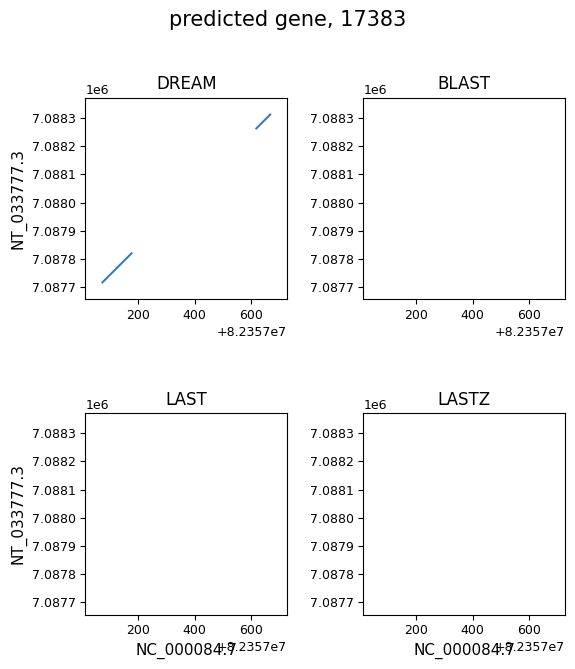

In [820]:
gene_id = "predicted gene, 17383"
qname = "NT_033777.3"
up = 7088412.0	
low = 7087617.0

plot_gene_alignments_manual(gene_id, qname, upper_lim = up, lower_lim = low)

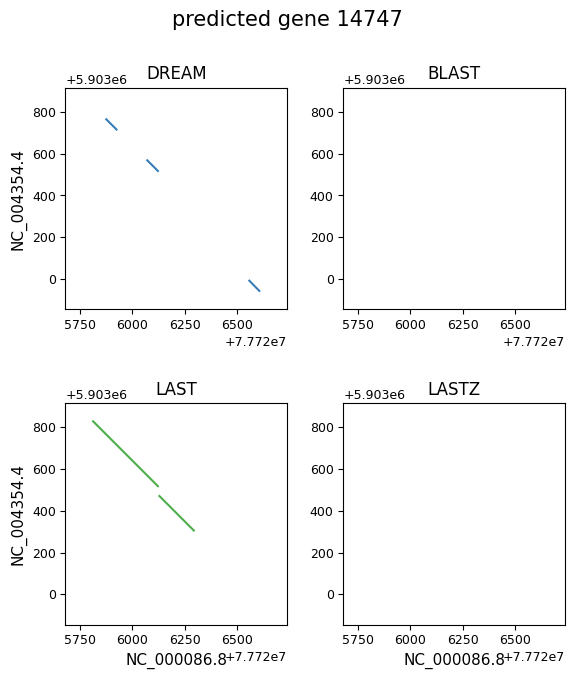

In [821]:
gene_id = "predicted gene 14747"
qname = "NC_004354.4"
up = 5903864.0	
low = 5902844.0

plot_gene_alignments_manual(gene_id, qname, upper_lim = up, lower_lim = low)

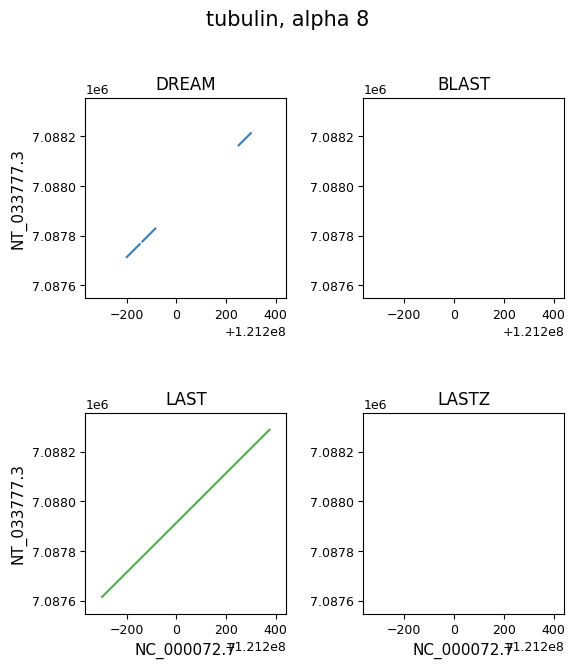

In [822]:
gene_id = "tubulin, alpha 8"	
qname = "NT_033777.3"
up = 7088313.0	
low = 7087614.0

plot_gene_alignments_manual(gene_id, qname, upper_lim = up, lower_lim = low)

In [823]:
if (explore):
    for gene_id in np.unique(feat_of_interest.name):
        print(gene_id)
        plot_gene_alignments(gene_id)

#### BLAST missing

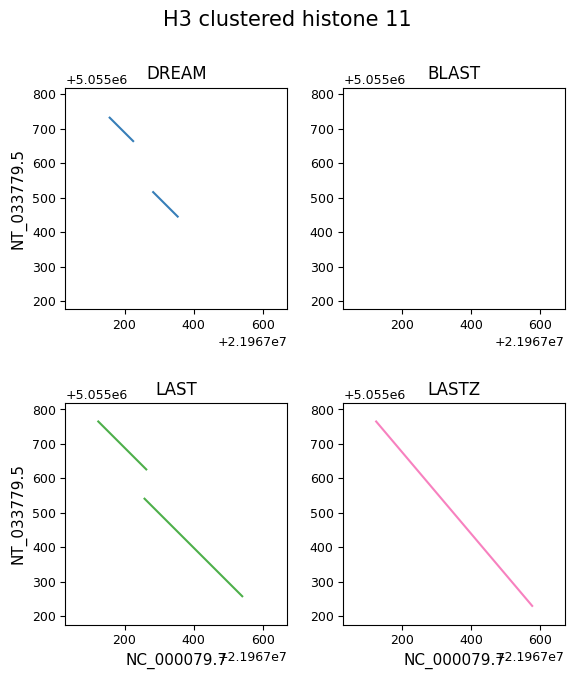

In [824]:
gene_id = "H3 clustered histone 11"
qname = "NT_033779.5"

plot_gene_alignments_manual(gene_id, qname, upper_lim = 1.5e7)

There are many examples for the H3 clustered histones

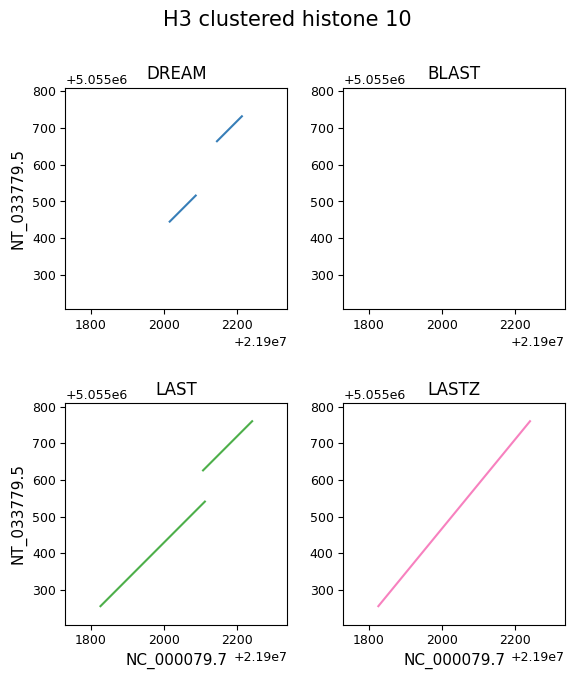

In [825]:
gene_id = "H3 clustered histone 10"
qname = "NT_033779.5"

plot_gene_alignments_manual(gene_id, qname, upper_lim = 1.5e7)

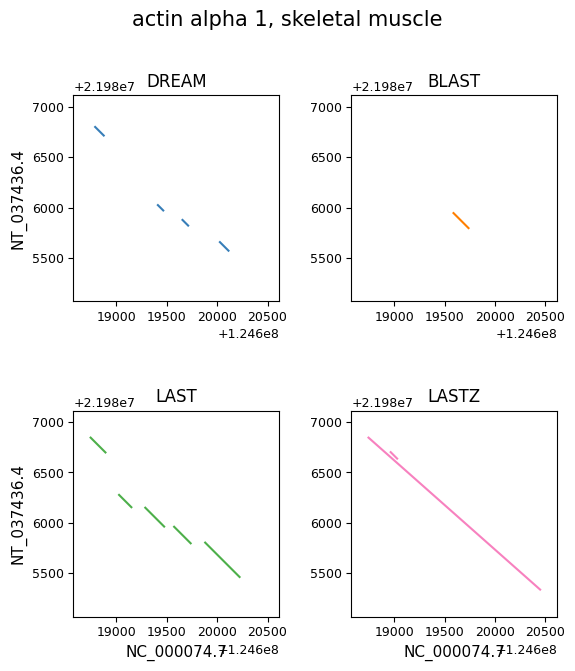

In [826]:
gene_id = "actin alpha 1, skeletal muscle"
qname = "NT_037436.4"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 1.75e7)

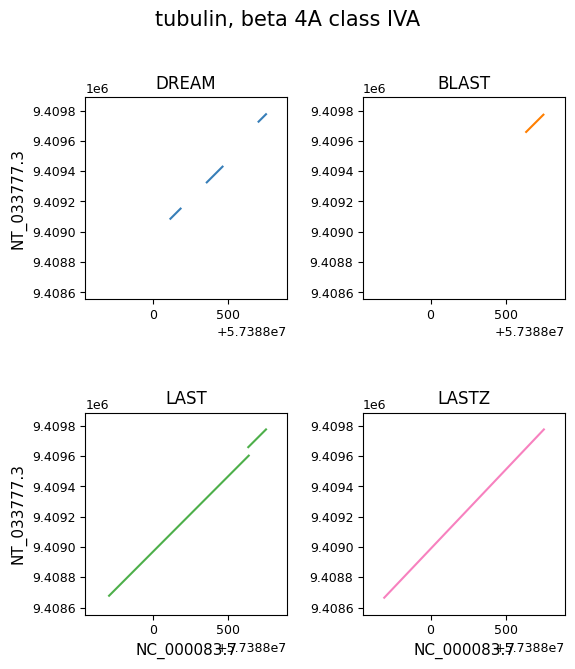

In [827]:
gene_id = "tubulin, beta 4A class IVA"
qname = "NT_033777.3"
plot_gene_alignments_manual(gene_id, qname, upper_lim = 2.0e7)

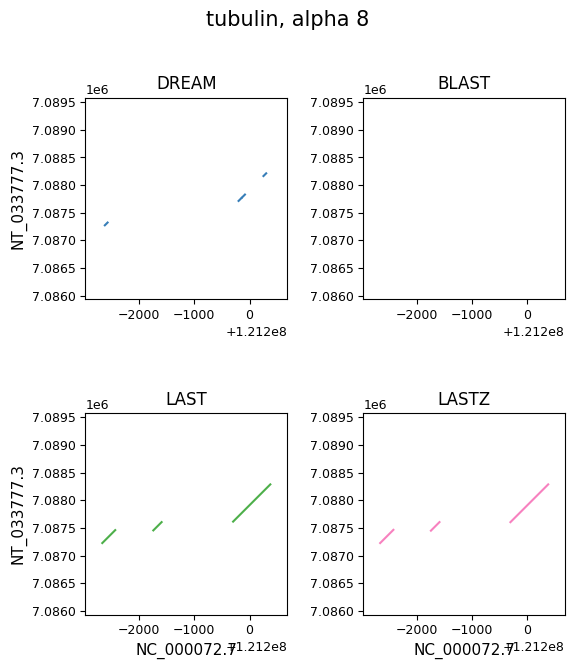

In [828]:
gene_id = "tubulin, alpha 8"
qname = "NT_033777.3"

plot_gene_alignments_manual(gene_id, qname, upper_lim = 7.3e6)

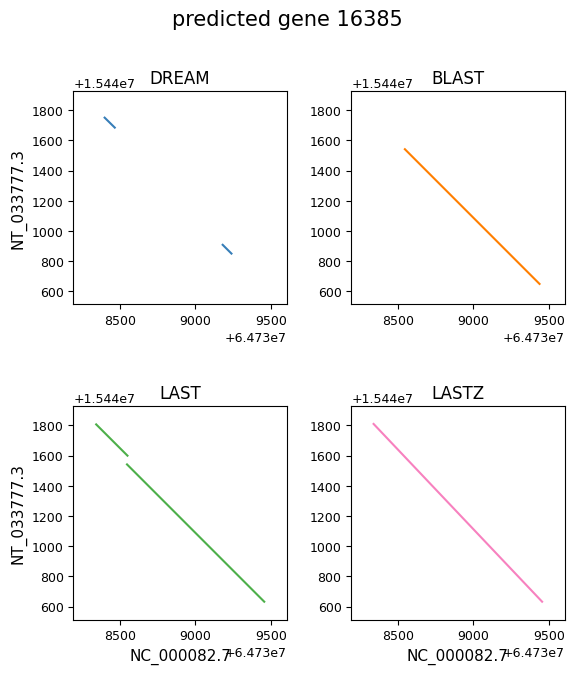

In [829]:
gene_id = "predicted gene 16385"
qname = "NT_033777.3"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 1.45e7)

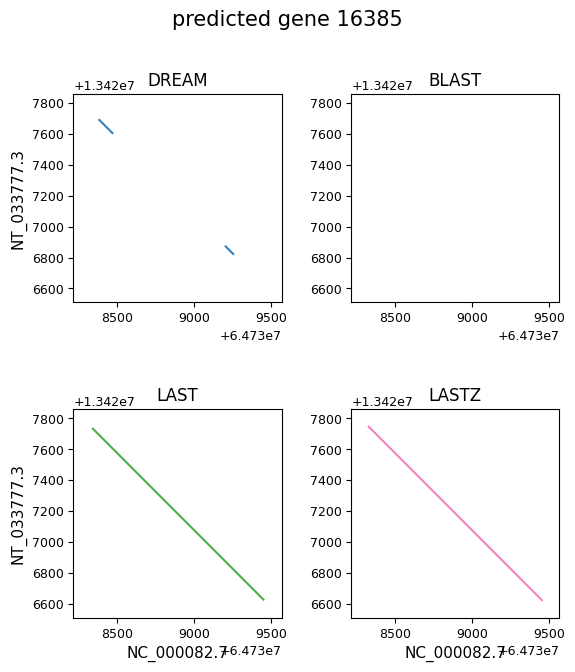

In [830]:
plot_gene_alignments_manual(gene_id, qname, upper_lim = 1.45e7, lower_lim = 1.32e7)

In [831]:
if (explore):
    fn2 = switch_reverse_coord(fn2)
    fn2 = fit_line_coord(fn2)
    fn2.head()

    match_sets, queries_of_interest = get_best_aligned(fn2, max_offset = 100, min_seq_count = 3, min_seq_range = 100)

    feat_of_interest = find_overlapping_features(match_sets)

    for index, row in feat_of_interest.iterrows():
        print(row["name"] + "\t" + row["qname"] + "\t" + str(row["upper_lim"]) + "\t" + str(row["lower_lim"]))
        plot_gene_alignments(row["name"], upper_lim = row["upper_lim"], lower_lim = row["lower_lim"])

#### LAST missing

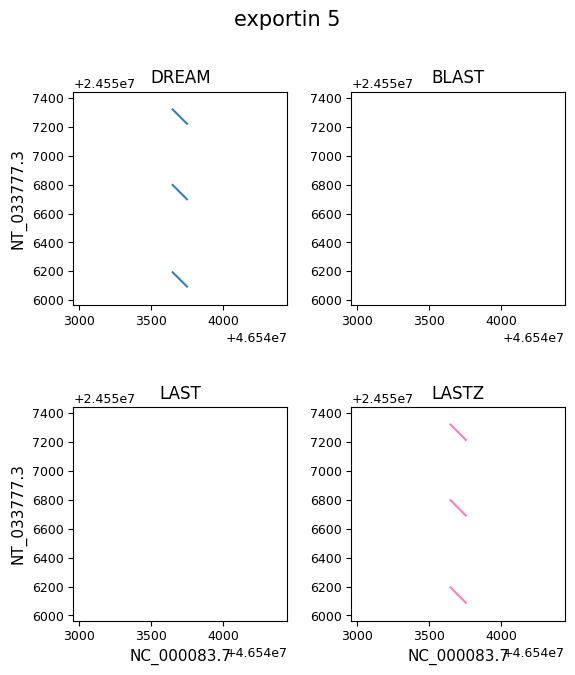

In [832]:
gene_id = "exportin 5"
qname = "NT_033777.3"

plot_gene_alignments_manual(gene_id, qname)

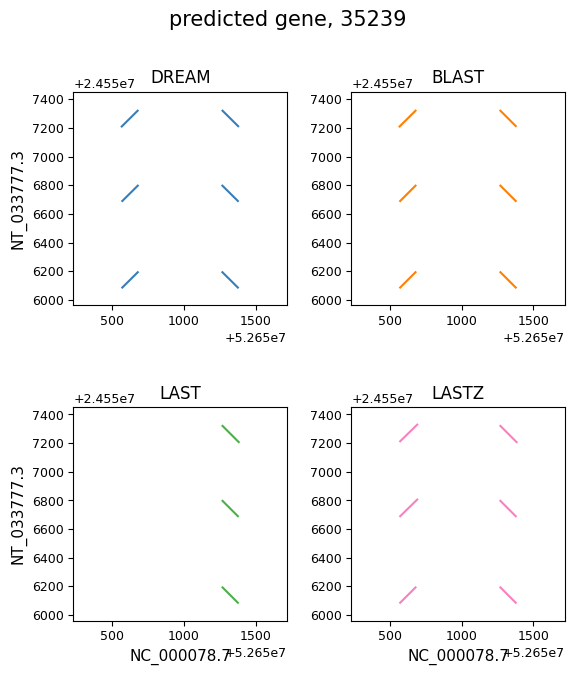

In [833]:
gene_id ="predicted gene, 35239"
qname = "NT_033777.3"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 2.35e7)

There are more examples where LAST misses the mirrored alignments

In [834]:
if (explore):
    fn1 = switch_reverse_coord(fn1)
    fn1 = fit_line_coord(fn1)
    fn1.head()

    match_sets, queries_of_interest = get_best_aligned_to_tp(fn1, dream_all, max_offset = 500, min_seq_count = 2, min_seq_range = 100)
    feat_of_interest = find_overlapping_features(match_sets)
    for index, row in feat_of_interest.iterrows():
        print(row["name"])
        plot_gene_alignments(row["name"], upper_lim = row["upper_lim"], lower_lim = row["lower_lim"])

#### LASTZ missed

In [835]:
if (explore):
    fn3 = switch_reverse_coord(fn3)
    fn3 = fit_line_coord(fn3)
    fn3.head()
    match_sets, queries_of_interest = get_best_aligned(fn3, max_offset = 100, min_seq_count = 1, min_seq_range = 100)
    feat_of_interest = find_overlapping_features(match_sets)
    for index, row in feat_of_interest.iterrows():
        print(row["name"] + "\t" + row["qname"] + "\t" + str(row["upper_lim"]) + "\t" + str(row["lower_lim"]))
        plot_gene_alignments(row["name"], upper_lim = row["upper_lim"], lower_lim = row["lower_lim"])

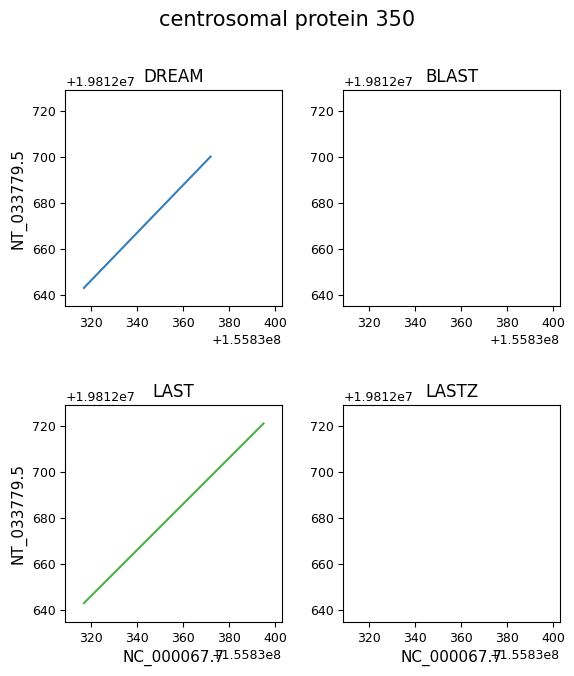

In [836]:
gene_id = "centrosomal protein 350"
qname = "NT_033779.5"
up = 19812800
low = 19812543

plot_gene_alignments_manual(gene_id, qname, upper_lim = up, lower_lim = low)

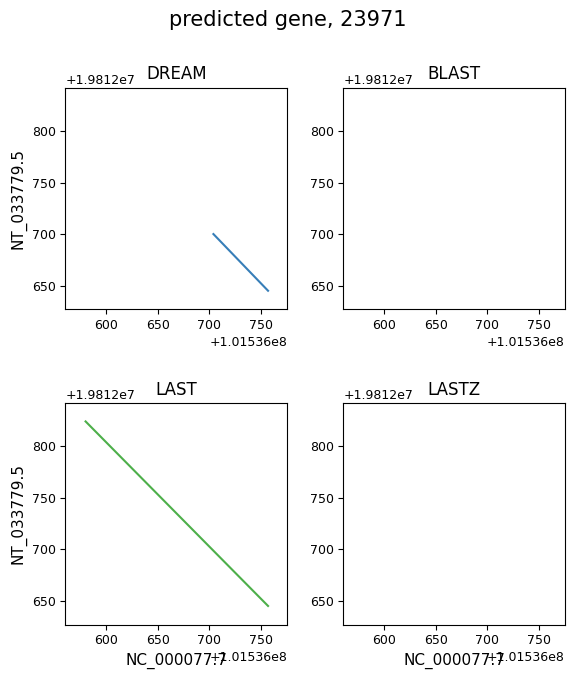

In [837]:
gene_id = "predicted gene, 23971"
qname = "NT_033779.5"
up = 19812800
low = 19812545

plot_gene_alignments_manual(gene_id, qname, upper_lim = up, lower_lim = low)

#### Edit distance vs affine gaps

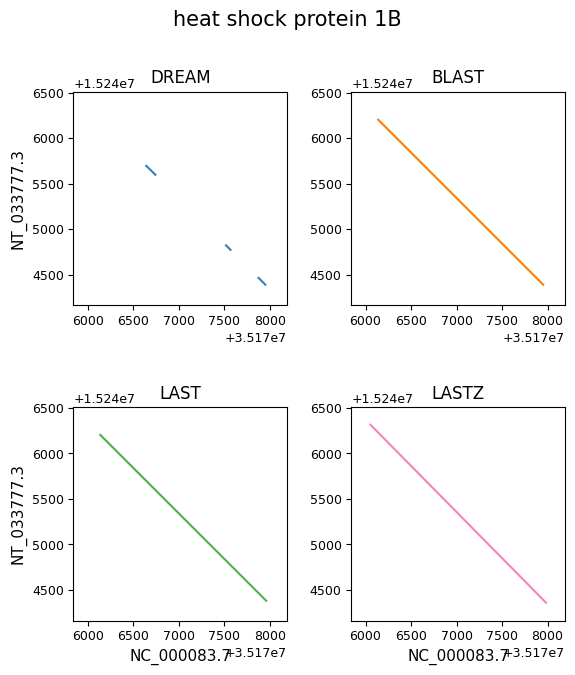

In [838]:
gene_id = "heat shock protein 1B"
qname = "NT_033777.3"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 1.35e7, upper_lim = 2e7)

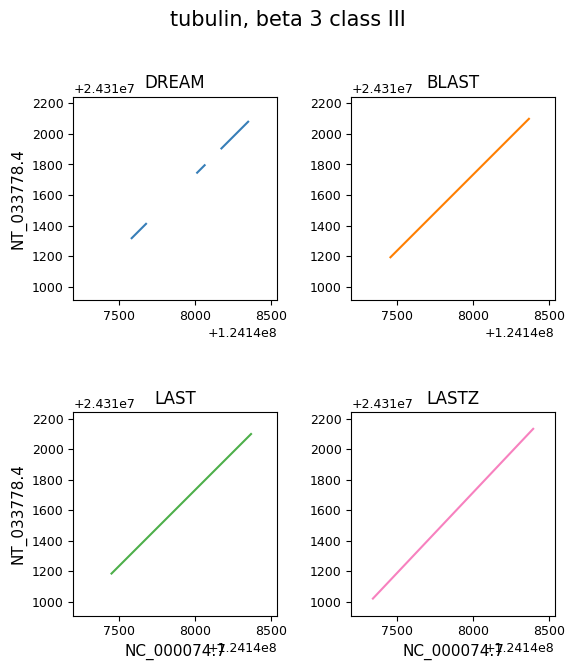

In [839]:
gene_id ="tubulin, beta 3 class III"
qname = "NT_033778.4"

plot_gene_alignments_manual(gene_id, qname, lower_lim = int(2.4308e7))

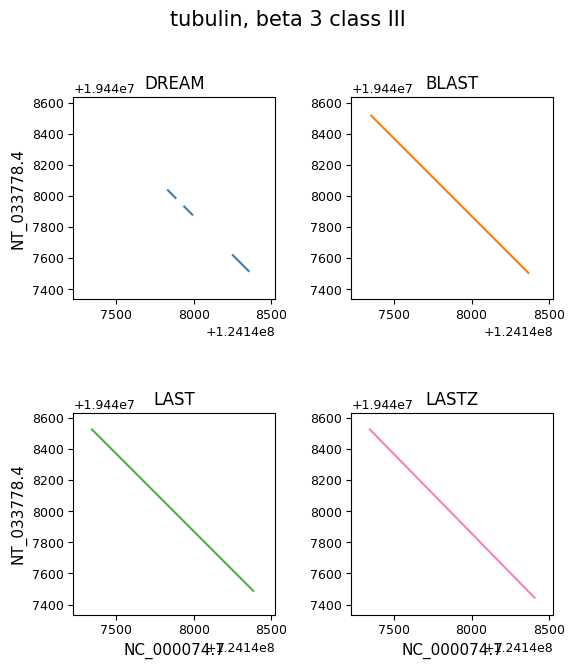

In [840]:
gene ="tubulin, beta 4A class IVA"
qname = "NT_033778.4"
plot_gene_alignments_manual(gene_id, qname, upper_lim = int(2.4e7))

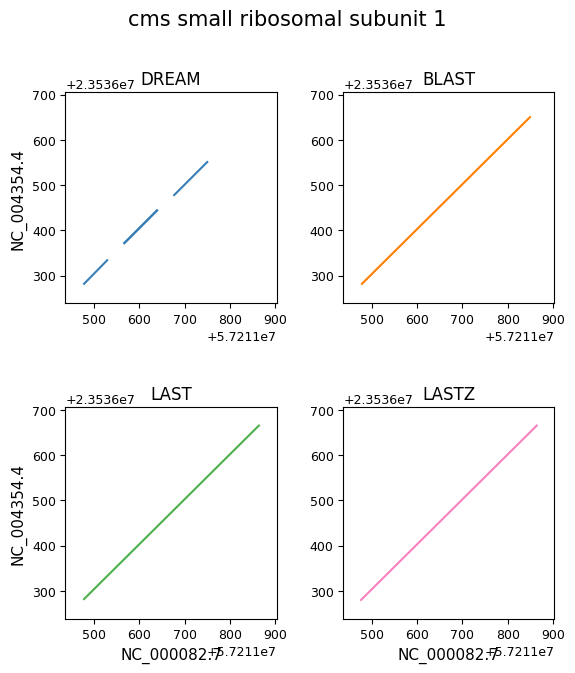

In [841]:
gene_id ="cms small ribosomal subunit 1"
qname = "NC_004354.4"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 2.35e7)

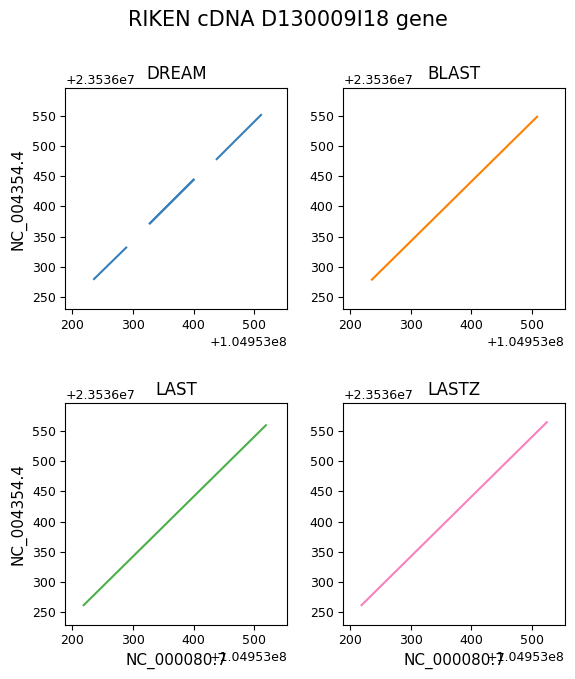

In [842]:
gene_id ="RIKEN cDNA D130009I18 gene"
qname = "NC_004354.4"

plot_gene_alignments_manual(gene_id, qname, lower_lim = 2.35e7)

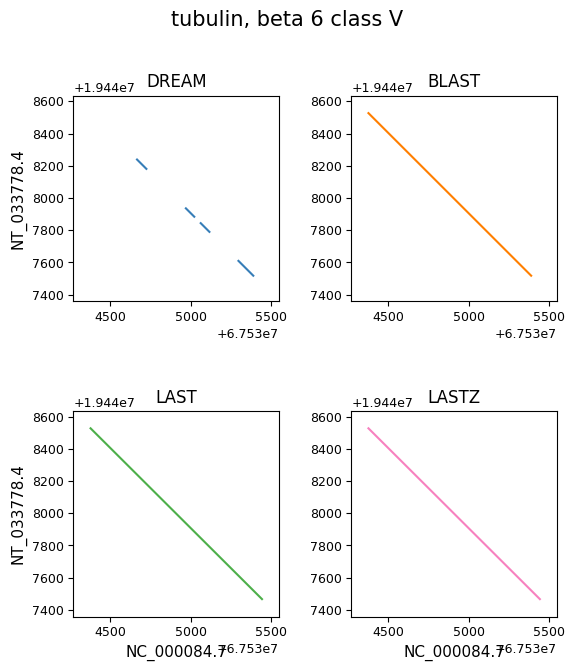

In [843]:
gene_id = "tubulin, beta 6 class V"
qname = "NT_033778.4"

plot_gene_alignments_manual(gene_id, qname, upper_lim = 2.2e7)

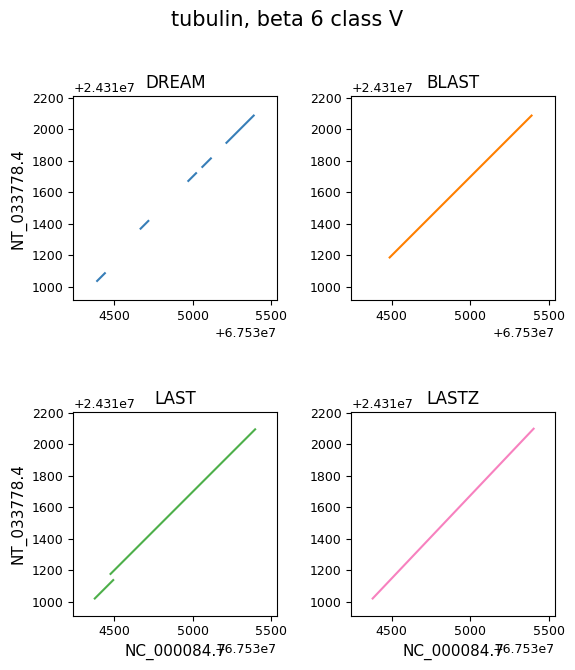

In [844]:
plot_gene_alignments_manual(gene_id, qname, lower_lim = 2.2e7)